In [1]:
import pandas as pd
import numpy as np
import feather
%matplotlib inline

df = pd.read_pickle('/home/SHARED/SOLAR/data/oahu_min_norm.pkl').set_index(['Datetime', 'Location'])

In [2]:
df.head()

Radiation                                GH       GT    ClearSky
Datetime                  Location                              
2010-03-19 14:15:00-10:00 AP1       476.328      NaN  973.629240
                          AP3       382.777      NaN  973.625962
                          AP4       351.610      NaN  973.624679
                          AP5       390.092      NaN  973.630994
                          AP6       353.928  343.313  973.628714

In [3]:
df.shape

(9058229, 3)

We need to:
  * set negative GH to 0
  * check if ClearSky is 0 when GH is 0
  * normalize GH to [0, 1] by dividing by ClearSky
  * check that GH norm is indeed in that interval

Replace negative values with 0

In [4]:
df['GH'] = df['GH'].where(df.GH >= 0, other=0)

In [5]:
df.describe()

Radiation,GH,GT,ClearSky
count,9.058229e+06,1.065674e+06,9.058229e+06
mean,3.699619e+02,3.120598e+02,6.120445e+02
std,3.510375e+02,3.448069e+02,3.727819e+02
min,0.000000e+00,-4.096800e-01,0.000000e+00
25%,4.230270e+01,3.153470e+01,2.401275e+02
50%,2.690470e+02,1.702540e+02,8.027669e+02
75%,6.195370e+02,5.199770e+02,9.003047e+02
max,1.700350e+03,1.587020e+03,1.022676e+03


Select rows where GH is 0 and ClearSky is not 0

In [6]:
gh = df.loc[np.isclose(df.GH, 0) & ~np.isclose(df.ClearSky, 0), ['GH', 'ClearSky']]

In [7]:
gh.shape

(648, 2)

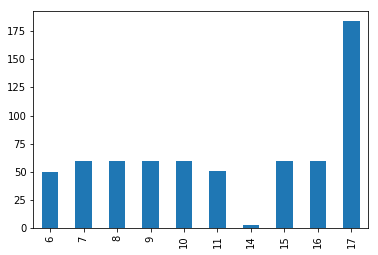

In [8]:
gh.index.get_level_values(level='Datetime').hour.value_counts().sort_index().plot(kind='bar');

Select rows where ClearSky is 0 and GH is not 0

In [9]:
cs = df.loc[~np.isclose(df.GH, 0) & np.isclose(df.ClearSky, 0), ['GH', 'ClearSky']]

In [10]:
cs.shape

(495325, 2)

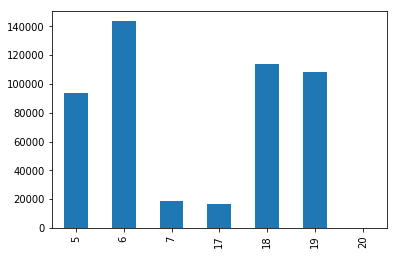

In [11]:
cs.index.get_level_values(level='Datetime').hour.value_counts().sort_index().plot(kind='bar');

What should we do with GH values where the ClearSky model is 0?? Here we set them to 1...

In [12]:
df['GHN'] = np.where(np.isclose(df['ClearSky'], 0), 1, df['GH']/df['ClearSky'])

In [13]:
df['GHN'].describe()

count    9.058229e+06
mean     1.549981e+00
std      6.514131e+01
min      0.000000e+00
25%      3.340713e-01
50%      6.381990e-01
75%      1.000000e+00
max      3.062428e+04
Name: GHN, dtype: float64

In [14]:
df['GHN'].quantile(q=[0.9, 0.99])

0.90    1.060668
0.99    2.477348
Name: GHN, dtype: float64

What should we do with GH values greater than the ClearSky model? They will result in a normalized GH > 1

In [15]:
df['GHN'].gt(1).agg([np.mean, np.sum])

mean    1.259946e-01
sum     1.141288e+06
Name: GHN, dtype: float64